In [2]:
import sys
from pathlib import Path

# Add the root directory to sys.path
sys.path.append("/home/charles/panda/catkin_ws/src/move_chess_panda/scripts")

In [3]:
import os
from pathlib import Path
import numpy as np
import shutil
import json
import matplotlib.pyplot as plt 
import cv2
import torch
import torchvision
import numpy as np
from pathlib import Path
import typing
from PIL import Image
from utili.recap import URI, CfgNode as CN

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from chessrec.preprocessing import gen_occ_data, gen_pie_data
from chessrec.core.dataset import build_dataset, build_data_loader, Datasets, unnormalize
from chessrec.core.models import build_model
from chessrec.core.statistics import StatsAggregator
from chessrec.core import device, DEVICE

def clean_folder(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
    else:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

def _csv(model: torch.nn.Module, agg: StatsAggregator, model_name: str, mode: Datasets) -> str:
    params = sum([np.prod(p.size()) for p in model.parameters()])
    return ",".join(map(str, [model_name,
                              mode.value,
                              params,
                              agg.accuracy(),
                              *map(agg.precision, agg.classes),
                              *map(agg.recall, agg.classes),
                              *map(agg.f1_score, agg.classes),
                              *agg.confusion_matrix.flatten()
                              ]))


def _csv_heading(classes: typing.List[str]) -> str:
    def class_headings(metric: str) -> typing.List[str]:
        return [f"{metric}/{c}" for c in classes]
    return ",".join(["model",
                     "dataset",
                     "parameters",
                     "accuracy",
                     *class_headings("precision"),
                     *class_headings("recall"),
                     *class_headings("f1_score"),
                     *(f"confusion_matrix/{i}/{j}"
                       for i in range(len(classes))
                       for j in range(len(classes)))])


def evaluate(model_path: Path, datasets: typing.List[Datasets], output_folder: Path, find_mistakes: bool = False, include_heading: bool = False) -> str:
    """Evaluate a model, returning the results as CSV.

    Args:
        model_path (Path): path to the model file
        datasets (typing.List[Datasets]): the datasets to evaluate on
        output_folder (Path): output folder for the mistake images (if applicable)
        find_mistakes (bool, optional): whether to output all mistakes as images to the output folder. Defaults to False.
        include_heading (bool, optional): whether to include a heading in the CSV output. Defaults to False.

    Raises:
        ValueError: if the YAML config file is missing

    Returns:
        str: the CSV string
    """
    model_file = model_path
    yaml_file = next(iter(model_path.parent.glob("*.yaml")))
    print(f"current model: {model_file}")
    model_name = model_file.stem
    cfg = CN.load_yaml_with_base(yaml_file)
    model = build_model(cfg)
    model.load_state_dict(torch.load(model_file, map_location=DEVICE))
    model = device(model)
    model.eval()

    datasets = {mode: build_dataset(cfg, mode)
                for mode in datasets}
    classes = next(iter(datasets.values())).classes

    csv = []
    if include_heading:
        csv.append(_csv_heading(classes))
    for mode, dataset in datasets.items():
        # Load dataset
        loader = build_data_loader(cfg, dataset, mode)
        # Compute statistics over whole dataset
        agg = StatsAggregator(classes)
        for images, labels in device(loader):
            predictions = model(images)
            agg.add_batch(predictions, labels, **(dict(inputs=images)
                                                  if find_mistakes else dict()))

        csv.append(_csv(model, agg, model_name, mode))
        if find_mistakes:
            groundtruth, mistakes = zip(*sorted(agg.mistakes,
                                                key=lambda x: x[0]))
            imgs = torch.tensor(mistakes).permute((0, 2, 3, 1))
            imgs = unnormalize(imgs).permute((0, 3, 1, 2))
            img = torchvision.utils.make_grid(imgs, pad_value=1, nrow=4)
            img = img.numpy().transpose((1, 2, 0)) * 255
            img = Image.fromarray(img.astype(np.uint8))
            mistakes_file = output_folder / \
                f"{model_name}_{mode.value}_mistakes.png"
            img.save(mistakes_file)
            groundtruth_file = output_folder / \
                f"{model_name}_{mode.value}_groundtruth.csv"
            with groundtruth_file.open("w") as f:
                f.write(",".join(map(str, groundtruth)))
        del model
        torch.cuda.empty_cache()
    return "\n".join(csv)


In [7]:
from chessrec.classifier import occ_models, piece_models

# Evaluate
whole_model_folder = Path("/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/to_benchmark/aftermove")
output_folder = Path("/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/evaluation")
output_folder.mkdir(parents=True, exist_ok=True)
# classifiers = ["occupancy_classifier", "piece_classifier"]
classifiers = ["piece_classifier"]
model_count = dict()
datasets = (Datasets.LOW, Datasets.LOW)
find_mistakes = False


for classifier in classifiers:
    subfolder = output_folder / classifier 
    # subfolder.mkdir(parents=True, exist_ok=True)
    output_csv = subfolder / "evaluate.csv"
    with output_csv.open("w") as f:
        models = list((whole_model_folder / classifier).glob("*.pt"))
        model_count[classifier] = len(models)
        # for i, model in enumerate(models):
        #     print(f"Processing {classifier} model {i+1}/{len(models)}")
        #     with torch.no_grad():
        #         f.write(evaluate(model, datasets, output_folder,
        #                         find_mistakes=find_mistakes,
        #                         include_heading=i == 0) + "\n")


In [4]:
from chessrec.classifier import occ_models, piece_models

#  Evaluate the selected models
best_model_folder = Path(f"/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models")
output_folder = Path("/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/evaluation/best_models")
clean_folder(output_folder)
classifiers = ["piece_classifier"]
datasets = (Datasets.TEST, Datasets.TEST)
find_mistakes = True

output_folder.mkdir(parents=True, exist_ok=True)
for classifier in classifiers:
    subfolder = output_folder / classifier 
    clean_folder(subfolder)
    # subfolder.mkdir(parents=True, exist_ok=True)
    output_csv = subfolder / "evaluation.csv"
    with output_csv.open("w") as f:
        models = list((best_model_folder).glob("**/*.pt"))
        for i, model in enumerate(models):
            print(f"Processing {classifier} model {i+1}/{len(models)}")
            model.rename(model.parent / f"{model.parent.parent.stem}_{model.stem[-8:]}.pt")
            with torch.no_grad():
                f.write(evaluate(model, datasets, output_folder,
                                find_mistakes=find_mistakes,
                                include_heading=i == 0) + "\n")

In [6]:
for model in models:
    model.rename(model.parent / f"{model.parent.parent.stem}_{model.stem[-8:]}.pt")
models

/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/500_500_9_d/piece_classifier/500_500_9_d_step2000.pt
/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/500_500_9_d/piece_classifier/500_500_9_d_step1500.pt
/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/1000_1000_9_dANDr/piece_classifier/1000_1000_9_dANDr_step3200.pt
/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/500_500_16_d/piece_classifier/500_500_16_d_step2000.pt
/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/1000_500_16_dANDr/piece_classifier/1000_500_16_dANDr_step5900.pt
/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/1000_500_9_dANDr/piece_classifier/1000_500_9_dANDr_step2700.pt
/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/500_500_9_dANDr/piece_classifier/500_500_9_dANDr_nV

[PosixPath('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/500_500_9_d/piece_classifier/InceptionV3step2000.pt'),
 PosixPath('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/500_500_9_d/piece_classifier/InceptionV3step1500.pt'),
 PosixPath('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/1000_1000_9_dANDr/piece_classifier/InceptionV3step3200.pt'),
 PosixPath('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/500_500_16_d/piece_classifier/InceptionV3step2000.pt'),
 PosixPath('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/1000_500_16_dANDr/piece_classifier/InceptionV3step5900.pt'),
 PosixPath('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/best_models/1000_500_9_dANDr/piece_classifier/InceptionV3step2700.pt'),
 PosixPath('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts

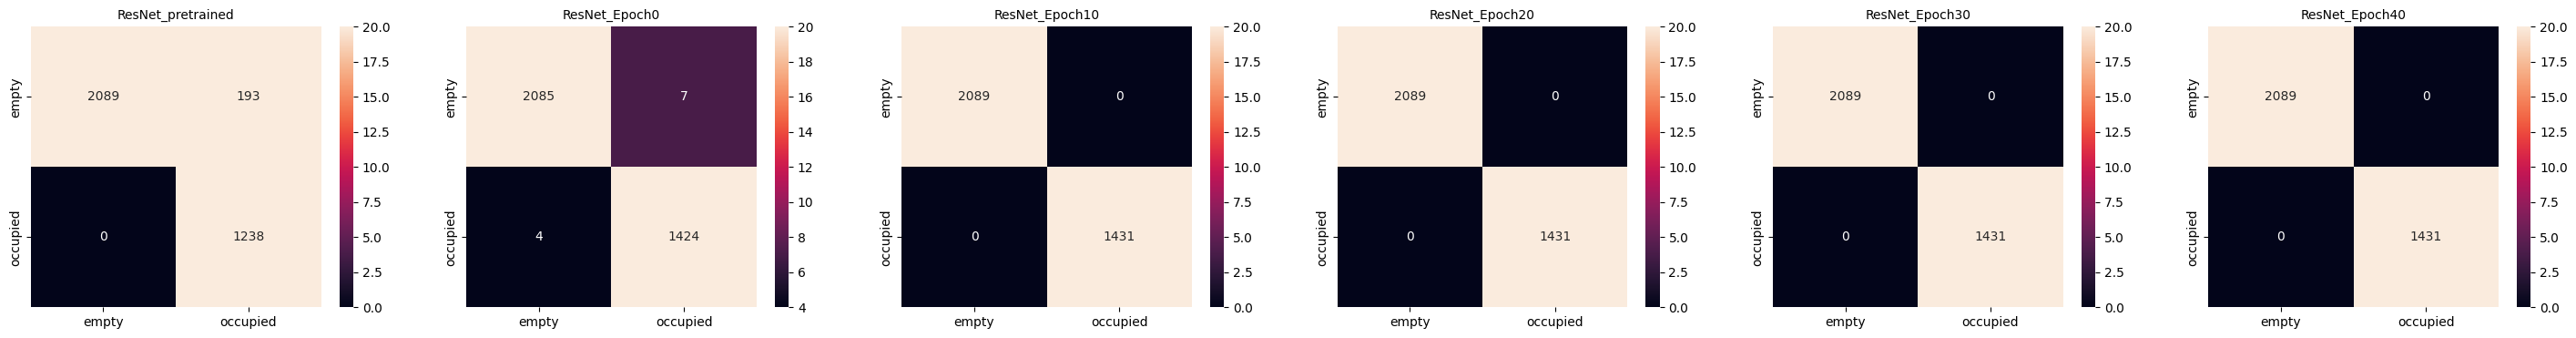

In [52]:
# load data from CSV file
data = pd.read_csv(output_folder / 'occupancy_classifier/evaluation.csv')
new_order = [0,2,3,4,5,1]
data = data.reindex(new_order).reset_index(drop=True)

# extract confusion matrix values
cms = data.filter(regex='model|dataset|^confusion')

num = model_count["occupancy_classifier"] if "occupancy_classifier" in model_count.keys() else 5

plt.rcParams["figure.figsize"]=num*6, 4
# plt.figure(figsize=(10,10))
fig, axs = plt.subplots(1, num)
for i, model in enumerate(data['model'].unique()):
    # for j, pose in enumerate(data['dataset'].unique()):
    # row = data[(data['model']==model) & (data['dataset']==pose)]
    row = data[(data['model']==model)]
    cm = np.array(row[['confusion_matrix/0/0', 'confusion_matrix/0/1', 'confusion_matrix/1/0', 'confusion_matrix/1/1']]).reshape((2,2))
    df_cm = pd.DataFrame(cm, index = ['empty','occupied'], columns = ['empty','occupied'])
    ax=axs[i]
    ax.set_title(f'{model}', fontsize=10)
    sns.heatmap(df_cm, ax=ax, vmax=20, annot=True, annot_kws={"size": 10}, fmt="d")
plt.savefig("occupancy_classification.png")

In [41]:
# data = pd.read_csv('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/evaluation/1000_1000_9_dANDrr/piece_classifier/evaluation.csv')
data = pd.read_csv('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/evaluation/best_models/evaluation.csv')
data = data.sort_values(by=['model']).sort_values(by=['dataset'])
new_order = [0, 4, 2, 6, 1, 5, 3, 7]
data

,model,dataset,parameters,accuracy,precision/black_bishop,precision/black_king,precision/black_knight,precision/black_pawn,precision/black_queen,precision/black_rook,...,confusion_matrix/11/2,confusion_matrix/11/3,confusion_matrix/11/4,confusion_matrix/11/5,confusion_matrix/11/6,confusion_matrix/11/7,confusion_matrix/11/8,confusion_matrix/11/9,confusion_matrix/11/10,confusion_matrix/11/11
4,1000_1000_9_d_step2200,d,24377080,0.992424,1.000000,1.000000,1.0,1.0,0.977778,1.000000,...,0,0,0,0,2,0,0,0,0,46
6,1000_500_16_d_step3800,d,24377080,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,39
2,500_500_16_d_step2000,d,24377080,0.997826,1.000000,0.969697,1.0,1.0,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,39
0,500_500_9_d_step1500,d,24377080,0.992424,1.000000,0.973684,1.0,1.0,1.000000,1.000000,...,0,0,0,0,0,0,1,0,0,46
5,1000_1000_9_dANDr_step3200,d+r,24377080,0.986264,0.945946,1.000000,1.0,1.0,1.000000,0.937500,...,0,0,0,0,0,0,1,0,0,45
7,1000_500_16_dANDr_step5900,d+r,24377080,0.993865,0.951220,1.000000,1.0,1.0,1.000000,1.000000,...,0,0,0,0,0,0,1,0,0,43
3,500_500_16_dANDr_step3500,d+r,24377080,0.993865,0.951220,0.987500,1.0,1.0,1.000000,0.970588,...,0,0,0,0,0,0,0,0,0,43
1,500_500_9_dANDr_step1500,d+r,24377080,0.979396,0.875000,1.000000,1.0,1.0,1.000000,0.957447,...,0,0,0,0,0,0,1,0,0,45


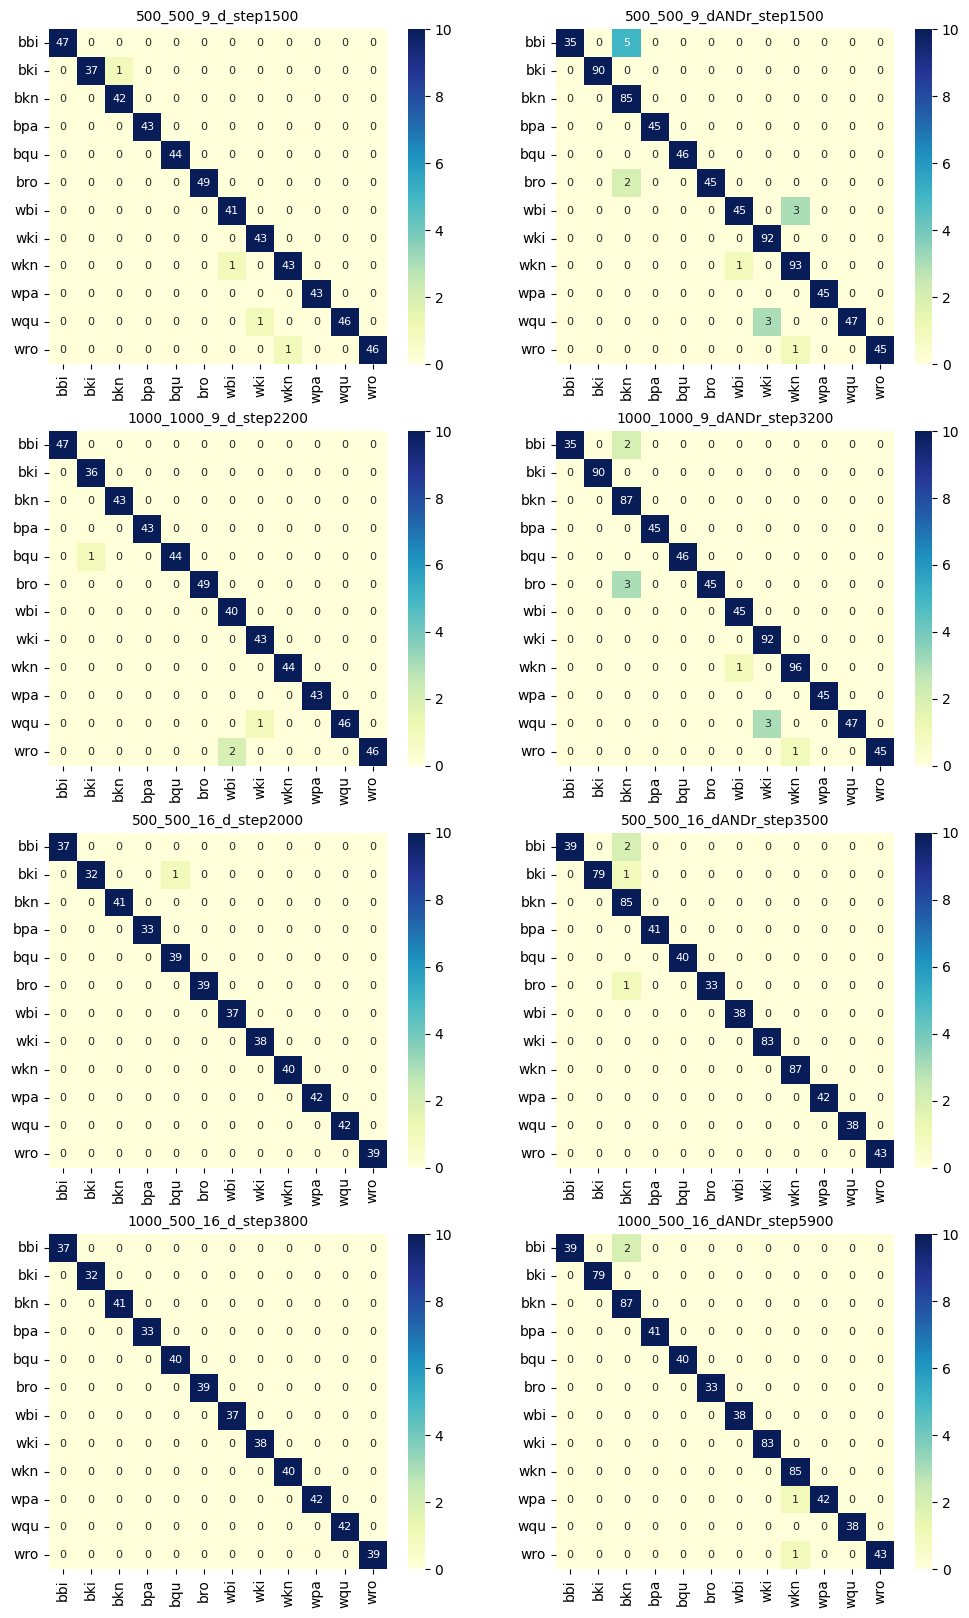

In [58]:
# load data from CSV file
# data = pd.read_csv('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/evaluation/piece_classifier/evaluation.csv')
data = pd.read_csv('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/evaluation/best_models/evaluation.csv')
data = data.sort_values(by=['model']).sort_values(by=['dataset'])
# new_order = [15, 9, 6, 12, 0, 3, 16, 10, 7, 13, 1, 4, 17, 11, 8, 14, 2, 5]
new_order = [0, 4, 2, 6, 1, 5, 3, 7]
data = data.reindex(new_order).reset_index(drop=True)
# num = model_count["piece_classifier"] if "piece_classifier" in model_count.keys() else 6
num = 4

# extract confusion matrix values
cms = data.filter(regex='model|dataset|^confusion')
names = data.filter(regex='^rec').columns.to_list()
for i, name in enumerate(names):
    names[i] = name[7]+name[13:15]

plt.rcParams["figure.figsize"]=3*num, 5*num
# plt.figure(figsize=(10,10))
fig, axs = plt.subplots(4, 2)
for i, model in enumerate(data['model'].unique()):
    # for j, pose in enumerate(data['dataset'].unique()):
    row = data[(data['model']==model)]
    cm = np.array(row.filter(regex='^conf')).reshape((12,12))
    df_cm = pd.DataFrame(cm, index = names, columns = names)
    y = i // 4
    x = i % 4
    ax=axs[x,y]
    ax.set_title(f'{model}', fontsize=10)
    sns.heatmap(df_cm, ax=ax, cmap='YlGnBu', vmax=10, annot=True, annot_kws={"fontsize": 8}, fmt='d')
# for i, model in enumerate(data['model'].unique()):
#     for j, pose in enumerate(data['dataset'].unique()):
#         row = data[(data['model']==model) & (data['dataset']==pose)]
#         # row = data[(data['model']==model)]
#         cm = np.array(row.filter(regex='^conf')).reshape((12,12))
#         df_cm = pd.DataFrame(cm, index = names, columns = names)
#         ax=axs[j,i]
#         ax.set_title(f'{model}', fontsize=10)
#         sns.heatmap(df_cm, ax=ax, cmap='YlGnBu', vmax=150, annot=True, annot_kws={"fontsize": 8}, fmt='d')
plt.savefig("piece_classification.png")

In [ ]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(data,  col='label0', )
fg.map_dataframe(draw_heatmap, 'label1', 'label2', 'value')

In [120]:
plt.rcParams["figure.figsize"]=10,7
data = pd.read_csv('/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/evaluation/piece_classifier/evaluate.csv')
df = data.filter(regex='model|dataset|^prec|^rec|^f1')
sns.boxplot(data=df, x="model", y='class', hue='dataset')

,model,dataset,precision/black_bishop,precision/black_king,precision/black_knight,precision/black_pawn,precision/black_queen,precision/black_rook,precision/white_bishop,precision/white_king,...,f1_score/black_knight,f1_score/black_pawn,f1_score/black_queen,f1_score/black_rook,f1_score/white_bishop,f1_score/white_king,f1_score/white_knight,f1_score/white_pawn,f1_score/white_queen,f1_score/white_rook
0,InceptionV3_Epoch0,low,0.994475,1.00,1.000000,1.000000,1.0,1.000000,0.988372,0.904110,...,1.000000,1.000000,0.990476,1.000000,0.971429,0.949640,0.995169,1.000000,0.965854,1.000000
1,InceptionV3_Epoch0,left,1.000000,0.75,1.000000,0.996319,1.0,1.000000,0.927083,0.796053,...,1.000000,0.998156,0.745562,1.000000,0.962162,0.852113,0.952854,0.998158,0.864078,0.966732
2,InceptionV3_Epoch0,right,0.983607,1.00,0.995261,1.000000,1.0,0.992481,1.000000,0.992481,...,0.997625,1.000000,0.975845,0.996226,1.000000,0.996226,0.997590,1.000000,0.995215,1.000000
3,InceptionV3_Epoch49,low,1.000000,1.00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,InceptionV3_Epoch49,left,1.000000,1.00,0.995261,0.998770,1.0,0.996226,1.000000,0.991736,...,0.997625,0.999385,0.990476,0.998110,1.000000,0.948617,0.997590,0.999387,0.945946,1.000000
5,InceptionV3_Epoch49,right,1.000000,1.00,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [117]:
data_t = data.transpose()
data_t.columns = data['model']
data_t[1:]

model,InceptionV3_Epoch0,InceptionV3_Epoch0,InceptionV3_Epoch0,InceptionV3_Epoch49,InceptionV3_Epoch49,InceptionV3_Epoch49
dataset,low,left,right,low,left,right
parameters,24377080,24377080,24377080,24377080,24377080,24377080
accuracy,0.994717,0.968594,0.997945,1.0,0.995304,1.0
precision/black_bishop,0.994475,1.0,0.983607,1.0,1.0,1.0
precision/black_king,1.0,0.75,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...
confusion_matrix/11/7,0,0,0,0,0,0
confusion_matrix/11/8,0,0,0,0,0,0
confusion_matrix/11/9,0,0,0,0,0,0
confusion_matrix/11/10,0,0,0,0,0,0


In [4]:
def clean_folder(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
    else:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

def chess_cmd_write_corners(chesscmd: HRIChessCommander, img_dir: Path, marker_type: str, write2img: bool=False):
    """write corners in pixels to the label folder for dataset generation

    Args:
        img_dir (Path): Path for the img folder

    Raises:
        ValueError: if the camera pose is not correct
    """
    imgs = img_dir.glob("*.[jp][pn]g")
    for img in imgs:
        if img.stem[-2:] == "gh":
            pose = "high"
        elif img.stem[-2:] == "ow":
            pose = "low"
        elif img.stem[-2:] == "ft":
            pose = "left"
        elif img.stem[-2:] == "ht":
            pose = "right"
        else:
            raise ValueError
        if pose not in chesscmd.cached_corners.keys():
            file_path = img
            img = cv2.imread(str(img))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            chesscmd.cur_robo_pose = pose
            img, corners = chesscmd.preprocess_img(img, pose, marker_type)
            np.savetxt((file_path.parent.parent / f"label/corner_{pose}.txt"), corners, delimiter=",")
            if write2img:
                fig = plt.figure()
                plt.imshow(img)
                plt.scatter(*corners.T, c="r")
                plt.axis("off")
                plt.savefig(file_path.parent.parent / f"label/corner_{pose}.jpg")
                print("saved the image with corner in the label folder")
        if len(chesscmd.cached_corners) == 4:
            break

def chess_cmd_write_labels(data_path, out_path):
    """write labels in jsons

    Args:
        data_path (Path): Path for the data folder that contains a img folder and a label folder
        out_path (Path): Path for output imgs and labels in the same folder

    Raises:
        ValueError: if the camera pose is not correct
    """
    cam_poses = ["high", "low", "left", "right"]
    use_pose = cam_poses[1:]
    data_count = 0
    multi_pose = True
    images = Path(data_path / "img").glob("*.[jp][pn]g")
    for img_path in images:
        img_name = img_path.stem
        img_count = img_name[:2]
        cam_pose = img_name[3:]
        if cam_pose not in use_pose:
            continue
        if img_path.suffix == ".jpg":
            img = cv2.imread(str(img_path))
            cv2.imwrite(str(out_path / f"{data_count}.png"), img)
        else:
            shutil.copy(str(img_path), str(out_path / f"{data_count}.png"))
        # update labels
        label_dict = dict()
        label_path = data_path / f"label/{img_count}.txt"
        label_dict["white_turn"] = True
        label_dict["fen"] = np.genfromtxt(label_path, dtype=str, delimiter=" ")[0]
        if multi_pose:
            corner_path = data_path / f"label/corner_{cam_pose}.txt"
        else:
            corner_path = data_path / "label/corner.txt"
        label_dict["corners"] = np.genfromtxt(corner_path, dtype=np.int16, delimiter=",").tolist()
        json_file = out_path / f"{data_count}.json"
        with json_file.open("w") as f:
            json.dump(label_dict, f)
        data_count += 1


In [5]:
data_dir = Path("/home/charles/panda/catkin_ws/src/move_chess_panda/scripts/data/collect/03_02_14_54")
test_dir = Path.home() / "panda/catkin_ws/src/move_chess_panda/scripts/data/collect/test"

test_case = HRIChessCommander(cam=False)
labels = (data_dir / "label").glob("[0-9]*.txt")
imgs = (data_dir / "img").glob("*.[jp][pn]g")

clean_folder(test_dir)
chess_cmd_write_corners(chesscmd=test_case, img_dir= data_dir / "img", marker_type="DICT_4X4_50")
chess_cmd_write_labels(data_path=data_dir, out_path=test_dir)


model searching path: /home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/transfer_learning_3sides_v3/occupancy_classifier
model searching path: /home/charles/panda/catkin_ws/src/move_chess_panda/scripts/chessrec/runs/transfer_learning_3sides_v3/piece_classifier
not to request an image because the no-cam mode 
corners [[ 716.0448161   306.94231035]
 [1189.84116259  285.57903893]
 [1379.64060415  715.40340992]
 [ 783.81443032  809.38298048]]
markers [[ 682.  284.]
 [1426.  743.]
 [ 751.  854.]]
left
corners [[ 716.0448161   306.94231035]
 [1189.84116259  285.57903893]
 [1379.64060415  715.40340992]
 [ 783.81443032  809.38298048]]
markers [[ 682.  284.]
 [  nan   nan]
 [1426.  743.]
 [ 751.  854.]]
not to request an image because the no-cam mode 
corners [[ 764.29647741  314.28821422]
 [1236.23300627  290.42567309]
 [1351.16260114  746.41843486]
 [ 730.12203299  779.87697347]]
markers [[ 737.  295.]
 [1259.  267.]
 [1396.  777.]
 [ 699.  811.]]
corners [[ 764.2964774